<a href="https://colab.research.google.com/github/benmsanderson/scenariopca/blob/main/pyam_scenario_PCA_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you run this in Google Colab, you will need to uncomment and run the cell
below to install necessary packages. If you are running locally, instead create
a new virtual environment and install dependencies with one of the following
commands:

- Using pip: `pip install -r requirements.txt`
- Using conda: `conda install --file requirements.txt`

In [1]:
# %pip install "pyam-iamc>=2.2"
# %pip install "pandas>=2.2"
# %pip install "unfccc-di-api"
# %pip install "eofs"
# %pip install "corner"
# %pip install "fsspec"
# %pip install "ipykernel"

In [2]:
import pandas as pd
import pyam as pyam
#import fsspec
import pkg_resources
import unfccc_di_api

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import sys
from eofs.multivariate.standard import MultivariateEof
import corner as corner


/tmp/ipykernel_24864/912006699.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


#Connect to IAM database

In [3]:


conn = pyam.iiasa.Connection()
conn.valid_connections


/opt/miniconda3/envs/diamond_scenariopca/lib/python3.12/site-packages/pyam/iiasa.py:167: DeprecationWarning: This method is deprecated and will be removed in future versions. Please run `ixmp4 login <username>` in a console and manually delete the file '/home/janko/.local/pyam/iiasa.yaml'. Using a pyam-credentials file
  self.auth = SceSeAuth(creds=creds, auth_url=self._auth_url)
[INFO] 22:32:53 - pyam.iiasa: You are connected as user `jikorsbakken`
[WARNING] 22:32:53 - pyam.iiasa: IIASA is migrating to a database infrastructure using the ixmp4 package.Use `pyam.iiasa.platforms()` to list available ixmp4 databases.


['ngfs_phase_3',
 'iamc15',
 'openentrance',
 'integration-test',
 'cdlinks',
 'india_scenario_hub',
 'genie',
 'hotspots',
 'commit',
 'kopernikus_public',
 'nexus-basins',
 'ngfs_phase_4',
 'senses',
 'aqnea',
 'navigate',
 'climate_solutions',
 'eu-climate-advisory-board',
 'engage',
 'nca5',
 'ar6-public',
 'deeds',
 'ngfs_phase_2',
 'gei',
 'netzero2040',
 'ripples',
 'ssp',
 'ecemf',
 'set_nav',
 'cmin',
 'ariadne',
 'paris_lttg']

In [4]:
conn = pyam.iiasa.Connection('ar6-public')

/opt/miniconda3/envs/diamond_scenariopca/lib/python3.12/site-packages/pyam/iiasa.py:167: DeprecationWarning: This method is deprecated and will be removed in future versions. Please run `ixmp4 login <username>` in a console and manually delete the file '/home/janko/.local/pyam/iiasa.yaml'. Using a pyam-credentials file
  self.auth = SceSeAuth(creds=creds, auth_url=self._auth_url)
[INFO] 22:32:54 - pyam.iiasa: You are connected to the IXSE_AR6_PUBLIC scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ece.iiasa.ac.at/ar6/#/about
[INFO] 22:32:54 - pyam.iiasa: You are connected as user `jikorsbakken`


In [5]:
conn.scenarios()

0                                1
1                EN_INDCi2030_1000
2                EN_INDCi2030_500f
3                EN_INDCi2030_600f
4                EN_INDCi2030_700f
                   ...            
1384              SSP2_SPA2_19I_RE
1385       Directed Transition 1.0
1386                     2C-hybrid
1387    DISCRATE_cb600_cdrall_dr4p
1388                      SSP2_5.0
Name: scenario, Length: 1389, dtype: object

In [6]:
conn.regions().head()

0                    World
1    Sao Tome and Principe
2             Turkmenistan
3             Saint Helena
4                Lithuania
Name: region, dtype: object

#Query database

Search for fields

In [7]:
 #pd.set_option('display.max_colwidth', -1)
 vars=conn.variables()



In [8]:
vars[vars.str.contains("Temperature") & vars.str.contains("MAGICC") & vars.str.contains("50")].to_list()

['AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile']

Construct Dataframe

In [9]:

df = conn.query(
    model='*',
    variable=['Carbon Sequestration|Land Use','Carbon Sequestration|CCS','Primary Energy|Nuclear', 'Primary Energy|Oil','Primary Energy|Gas','Primary Energy|Fossil','Primary Energy|Coal','Emissions|CO2|Energy and Industrial Processes','Emissions|CO2|AFOLU','Emissions|CH4','Emissions|N2O','Primary Energy|Non-Biomass Renewables','Primary Energy|Biomass','Final Energy','AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile'],
    region='World'
)

vs = [element.split('|')[-1:][0] for element in df.variable]
shv = {vs[i]: df.variable[i] for i in range(len(vs))}


In [10]:
df.meta

version Regional_scope  \
model             scenario                                         
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100        5         Global   
                  ADVANCE_2020_Med2C            4         Global   
                  ADVANCE_2020_WB2C             4         Global   
                  ADVANCE_2030_Med2C            4         Global   
                  ADVANCE_2030_Price1.5C        4         Global   
...                                           ...            ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi                  2         Global   
                  CD-LINKS_NPi2020_1000         2         Global   
                  CD-LINKS_NPi2020_1600         2         Global   
                  CD-LINKS_NPi2020_400          2         Global   
                  CD-LINKS_NoPolicy             2         Global   

                                                Category  \
model             scenario                                 
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100  failed-vetting   
                  ADVANCE_2020_Med2C      failed-vetting   
                  ADVANCE_2020_WB2C       failed-vetting   
                  ADVANCE_2030_Med2C      failed-vetting   
                  ADVANCE_2030_Price1.5C  failed-vetting   
...                                                  ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi                        C7   
                  CD-LINKS_NPi2020_1000               C1   
                  CD-LINKS_NPi2020_1600               C3   
                  CD-LINKS_NPi2020_400                C1   
                  CD-LINKS_NoPolicy                   C7   

                                                                              Category_name  \
model             scenario                                                                    
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100                                     failed-vetting   
                  ADVANCE_2020_Med2C                                         failed-vetting   
                  ADVANCE_2020_WB2C                                          failed-vetting   
                  ADVANCE_2030_Med2C                                         failed-vetting   
                  ADVANCE_2030_Price1.5C                                     failed-vetting   
...                                                                                     ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi                              C7: limit warming to 4°C (>50%)   
                  CD-LINKS_NPi2020_1000   C1: limit warming to 1.5°C (>50%) with no or l...   
                  CD-LINKS_NPi2020_1600                     C3: limit warming to 2°C (>67%)   
                  CD-LINKS_NPi2020_400    C1: limit warming to 1.5°C (>50%) with no or l...   
                  CD-LINKS_NoPolicy                         C7: limit warming to 4°C (>50%)   

                                          CO2 emissions reductions 2019-2020 % modelled Native  \
model             scenario                                                                       
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100                                          -1.215971      
                  ADVANCE_2020_Med2C                                              -1.236740      
                  ADVANCE_2020_WB2C                                               -1.236740      
                  ADVANCE_2030_Med2C                                              -1.248593      
                  ADVANCE_2030_Price1.5C                                          -1.287815      
...                                                                                     ...      
WITCH-GLOBIOM 4.4 CD-LINKS_NPi                                                    -1.419657      
                  CD-LINKS_NPi2020_1000                                           -1.419657      
                  CD-LINKS_NPi2020_1600                                           -1.419657      
                  CD-LINKS_NPi2020_400                        

In [11]:
years=np.arange(2010,2110,10)

#Define functions

Pivot table

In [12]:
def pivtab(x,catg='*'):
  tb={}
  itmp=[]

  for vrb in vs:
    print(vrb)
    filtb=x.filter(variable=shv[vrb],Category=catg).data
    unt=filtb.unit.unique()

    tmp=pd.pivot_table(filtb,index=['model','scenario'],columns='year',values=['value'])['value'][years]
    unt=unt[0][:]
    tb[vrb]=tmp
    tb[vrb].unit=unt
    itmp.append(tmp.index)
  ii=tb[list(tb)[0]].index
  for ij,vrb in enumerate(vs):
    ii=ii.intersection(itmp[ij])
  for vrb in vs:
    unt=tb[vrb].unit
    tb[vrb]=tb[vrb].loc[ii]
    tb[vrb].unit=unt
    tb[vrb].name=shv[vrb]
  return tb

In [13]:
df.meta.Category.unique()

array(['failed-vetting', 'C3', 'C5', 'C6', 'C7', 'C4', 'C1',
       'no-climate-assessment', 'C2', 'C8'], dtype=object)

Simple plots


In [14]:
def plt2d(x,y,t1=2050,t2=2050):
  if len(sys.argv) > 3:
    t2 = sys.argv[3]
  else:
    t2=t1
  p1=plt.scatter(tb[x][t1],tb[y][t2])
  plt.ylabel(shv[x]+' '+tb[x].unit)
  plt.xlabel(shv[y]+' '+tb[y].unit)
  plt.title(x+' '+str(t1)+' vs '+y+' '+ str(t2))
  return p1

In [15]:
def plt1d(x):
  p1=tb[x].T.plot(legend=False,color='lightgrey')
  tb[x].mean().plot(legend=False,color='k')
  plt.ylabel(shv[x]+' '+tb[x].unit)
  return p1


In [16]:
def getrun(x):
  dsamp=[]
  for i,ky in enumerate(kys):
    dsamp.append(tb[ky].iloc[[x]])
  dfrun = pd.concat(dsamp, ignore_index=False)
  dfrun.insert(0, "Variable", kys, True)
  dfrun.reset_index(drop=True, inplace=True)
  dfrun=dfrun.set_index(['Variable'])
  return dfrun

In [17]:
fields=['CCS','Oil','Coal','Gas','Land Use','CH4','AFOLU','Energy and Industrial Processes','N2O','Final Energy','Biomass','Non-Biomass Renewables','Nuclear','50.0th Percentile']


In [18]:
def contains_multiple_words(s):
  return len(s.split()) > 1
fld_shrt=[]
for i,f in enumerate(fields):
  if shv[f].split('|')[0:][0]=='Emissions':
    dm='em_'
  else:
    dm=''
  if contains_multiple_words(f):
    fld_shrt.append(dm+''.join([x[0].upper() for x in f.split(' ')]))
  else:
    fld_shrt.append(dm+f)
fld_shrt

['CCS',
 'Oil',
 'Coal',
 'Gas',
 'LU',
 'em_CH4',
 'em_AFOLU',
 'em_EAIP',
 'em_N2O',
 'FE',
 'Biomass',
 'NR',
 'Nuclear',
 '5P']

#Get data for low overshoot scenarios

In [19]:
df.head

<bound method IamDataFrame.head of <class 'pyam.core.IamDataFrame'>
Index:
 * model    : AIM/CGE 2.0, AIM/CGE 2.1, AIM/CGE 2.2, ... WITCH-GLOBIOM 4.4 (90)
 * scenario : ADVANCE_2020_1.5C-2100, ADVANCE_2020_Med2C, ... SSP4-19 (877)
Timeseries data coordinates:
   region   : World (1)
   variable : ... (15)
   unit     : EJ/yr, K, Mt CH4/yr, Mt CO2/yr, kt N2O/yr (5)
   year     : 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, ... 2100 (106)
Meta indicators:
   version (int64) 5, 4, 3, 2, 1, 6 (6)
   Regional_scope (object) Global, nan, Global-sectoral, ... National (5)
   Category (object) failed-vetting, C3, C5, C6, C7, C4, C1, ... C8 (10)
   Category_name (object) failed-vetting, ... C8: exceed warming of 4°C (>=50%) (10)
   CO2 emissions reductions 2019-2020 % modelled Native (float64) ... (1012)
   ...>

In [20]:
cls=[['C1','C2','C3'],['C1','C2']]

fld=[['CCS','Oil'],['CCS','Oil']]

In [21]:
def make_eof_in(df,cl,fl,fld_scl):
  tb=pivtab(df,[x for x in cl])
  kys=list(tb.keys())
  fld_scl=[100,1,1,1,100,1,100,100,100,1,1,1,1]
  eof_in=[]
  for i,f in enumerate(fields):
    eof_in.append(tb[f].to_numpy()/fld_scl[i])

In [22]:
 tb=pivtab(df,[x for x in ['C1','C2','C3','C4','C5','C6','C7','C8']])


50.0th Percentile
CCS


Land Use
CH4
AFOLU
Energy and Industrial Processes
N2O
Final Energy
Biomass
Coal
Fossil
Gas
Non-Biomass Renewables
Nuclear
Oil


Sanity plots for some sector timeseries

In [23]:
kys=list(tb.keys())

#MultiVariate EOF - energy sectors


In [24]:
#define normalisation of fields for PCA
fld_scl=[100,1,1,1,100,1,100,100,100,1,1,1,1,1]
eof_in=[]
for i,f in enumerate(fields):
  eof_in.append(tb[f].to_numpy()/fld_scl[i])



Make short titles for plots

#solve for EOFs

In [25]:
solver = MultivariateEof(eof_in, center=True)

/opt/miniconda3/envs/diamond_scenariopca/lib/python3.12/site-packages/eofs/multivariate/standard.py:112: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self._solver = standard.Eof(data,


In [26]:
fcdr=np.sign(solver.eofs()[0][:,5])

Plot first n EOFs for each component in multi-variate set

/opt/miniconda3/envs/diamond_scenariopca/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/miniconda3/envs/diamond_scenariopca/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/miniconda3/envs/diamond_scenariopca/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


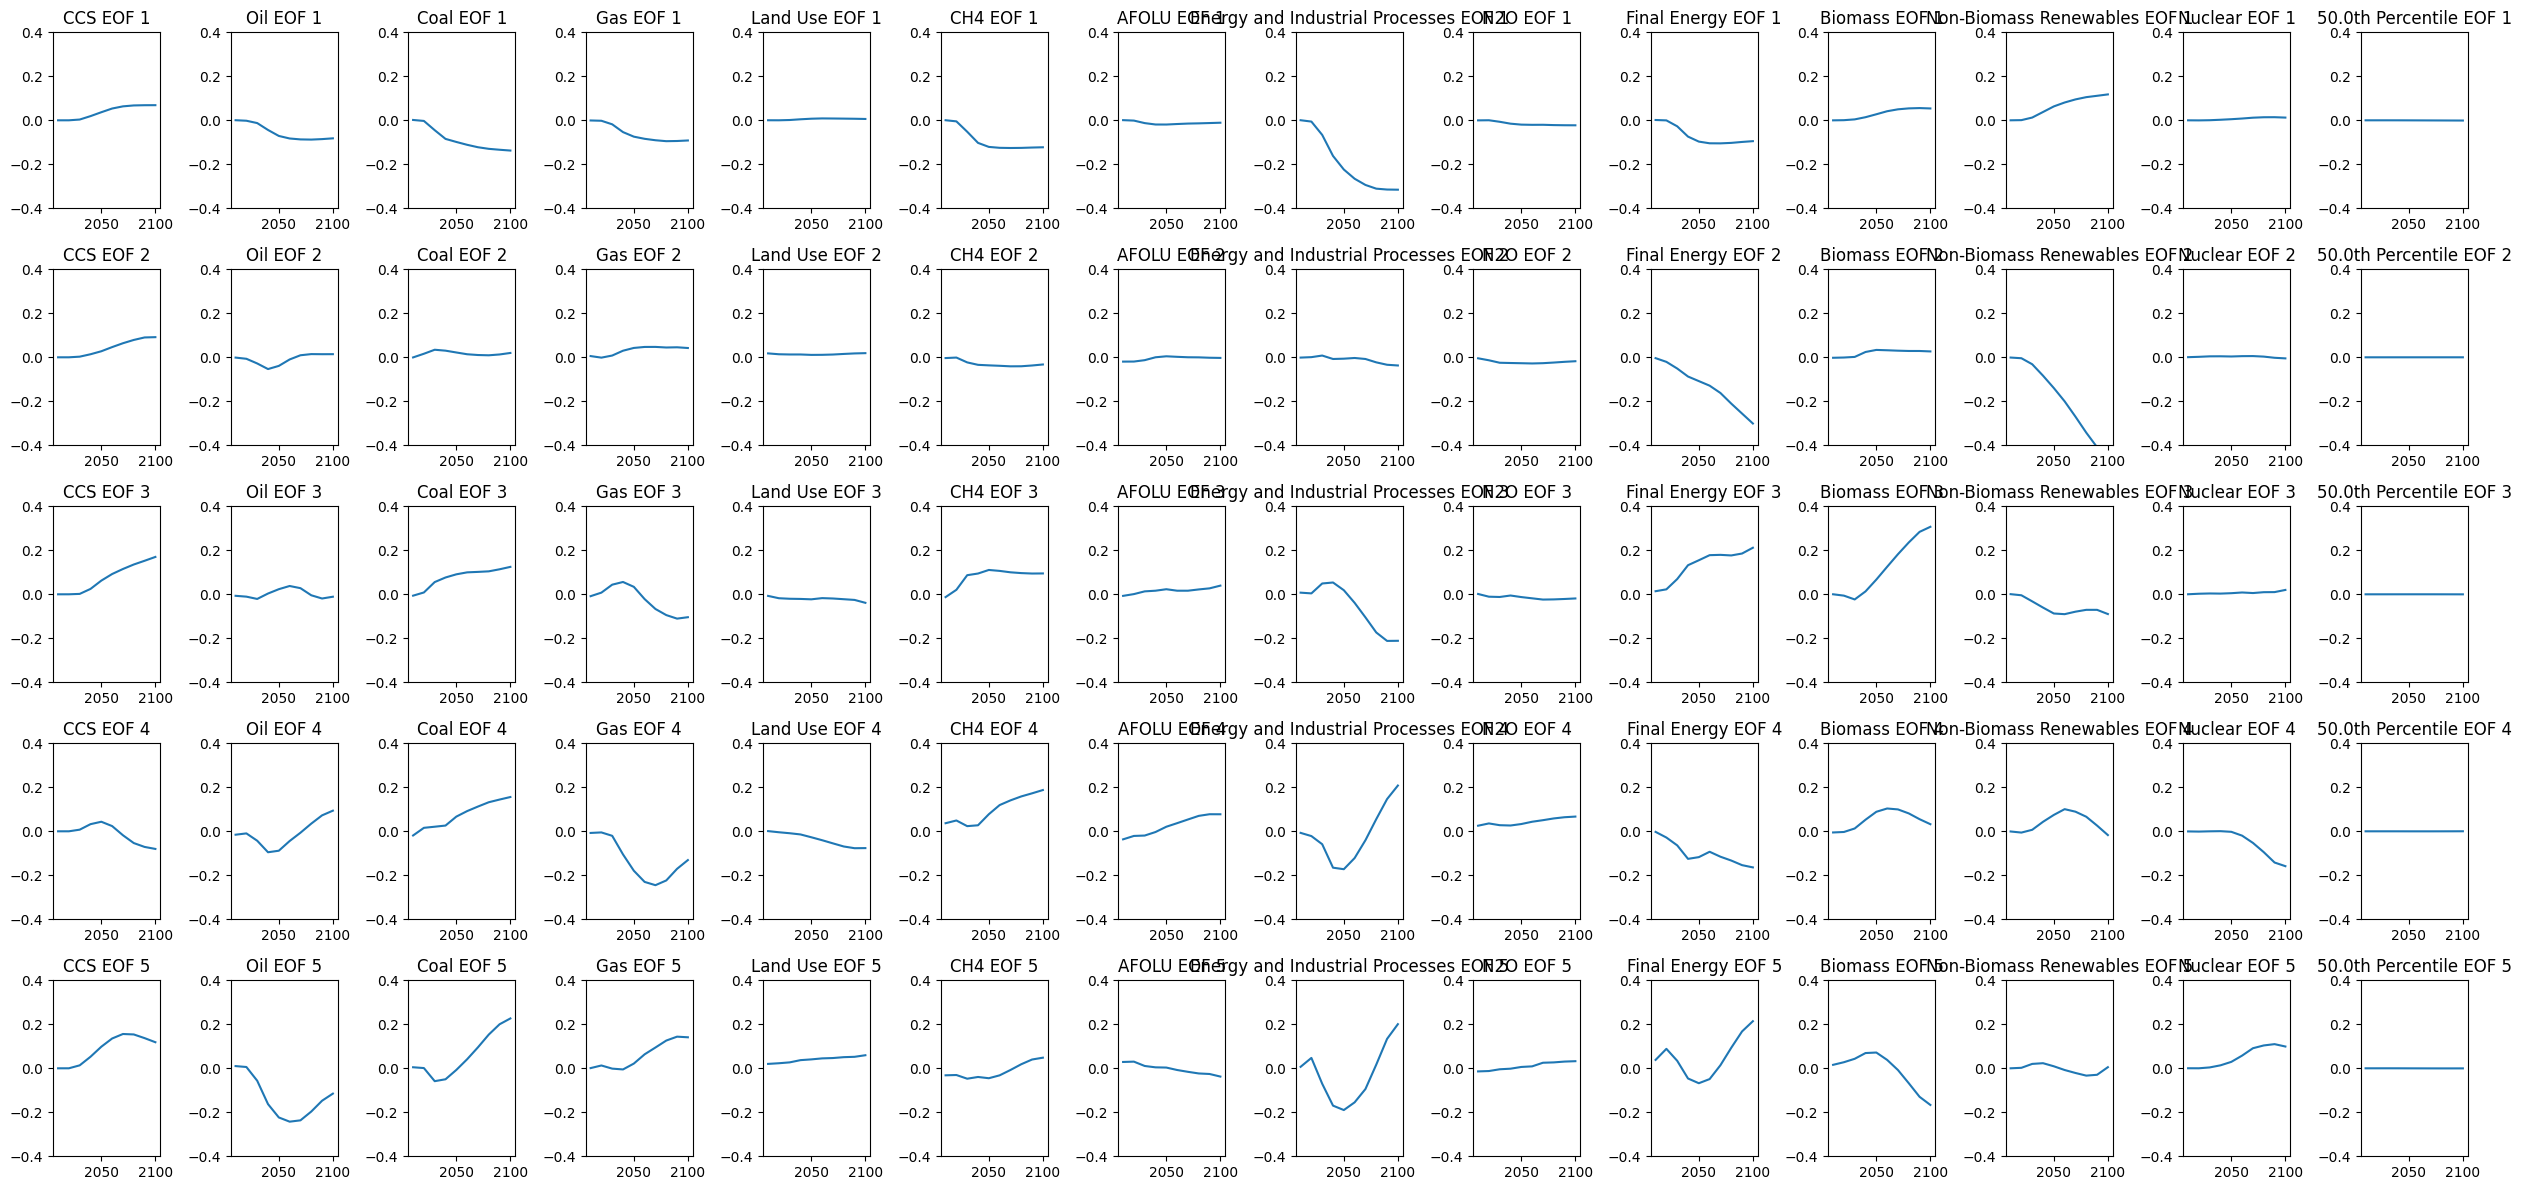

In [27]:

fig, ax = plt.subplots(nrows=5, ncols=len(fld_scl),figsize=(25,12))
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        col.plot(years,fcdr[i]*solver.eofs()[j][i,:])
        col.set_title(fields[j]+' EOF '+str(i+1))
        col.set_ylim(-0.4,0.4)
fig.tight_layout()

Pair plot to show distribution of scenarios in EOF space

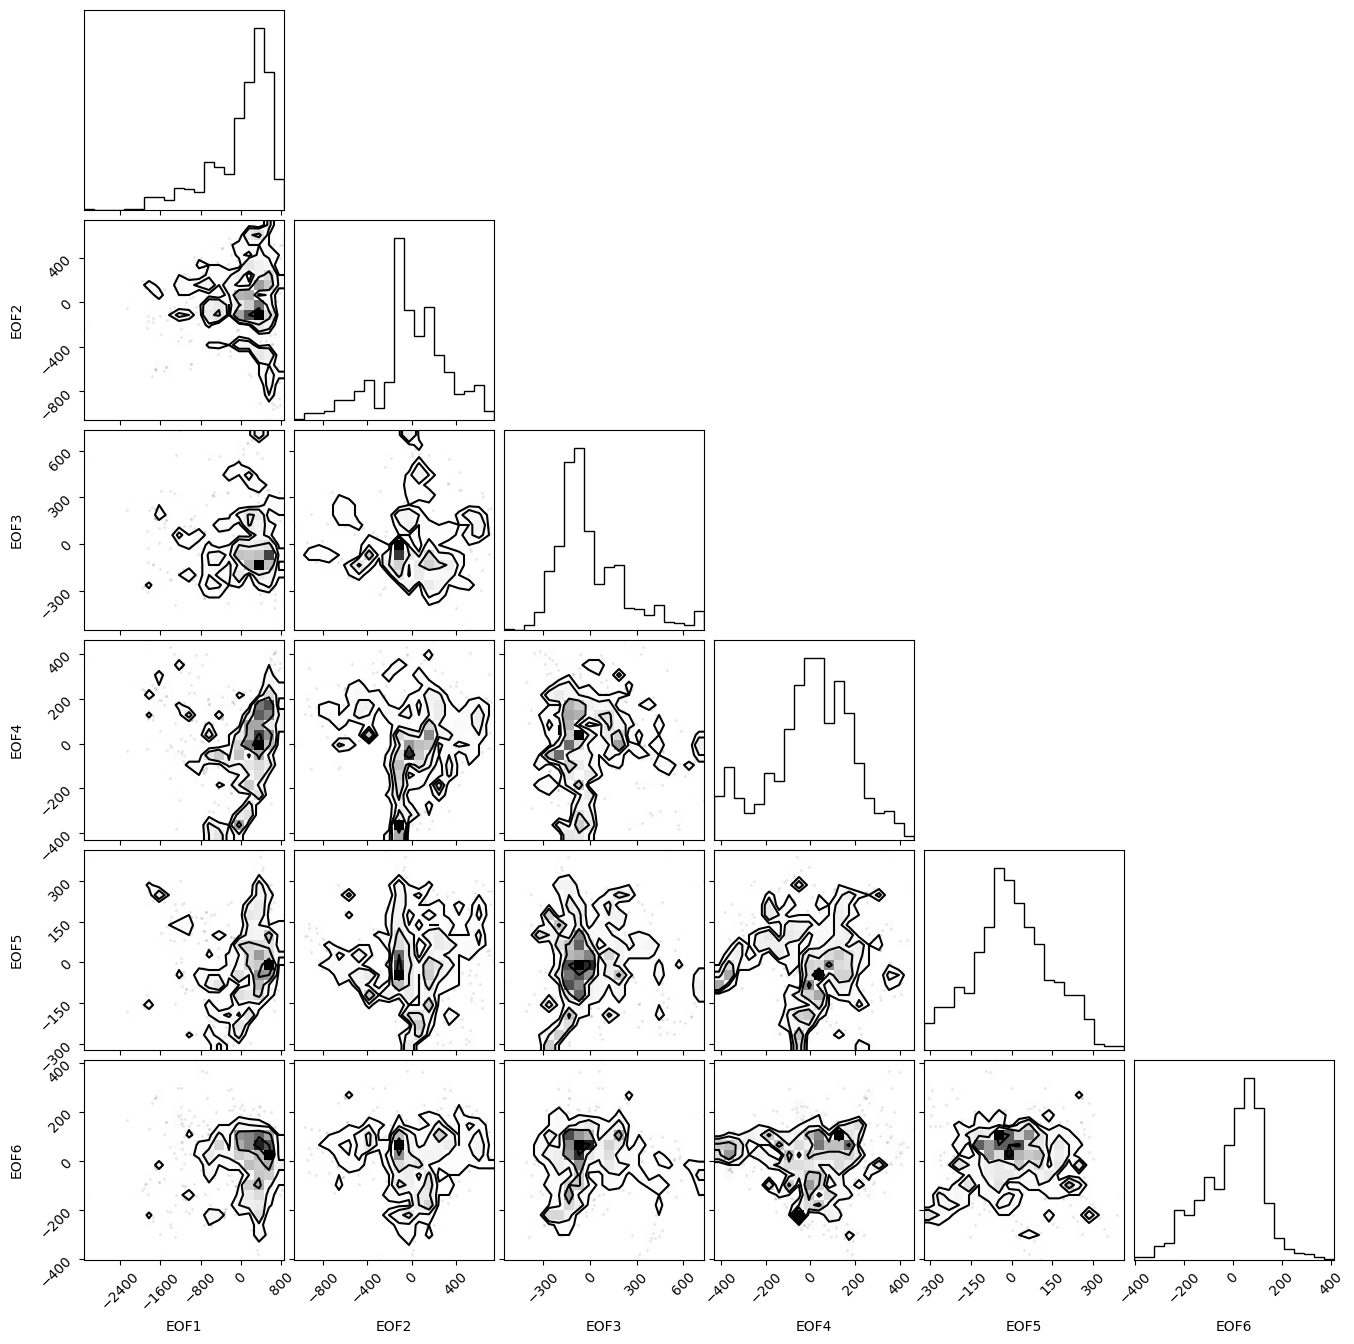

In [28]:
pcs=np.matmul(solver.pcs(npcs=6),np.diag(fcdr[0:6]))
figure = corner.corner(pcs,labels=["EOF1","EOF2","EOF3","EOF4","EOF5","EOF6"],hist2d_kwargs={"plot_datapoints": True,"plot_density": False, "plot_contours":False})

Plot scenario timeseries, colored according to whether they are high/low in each EOF

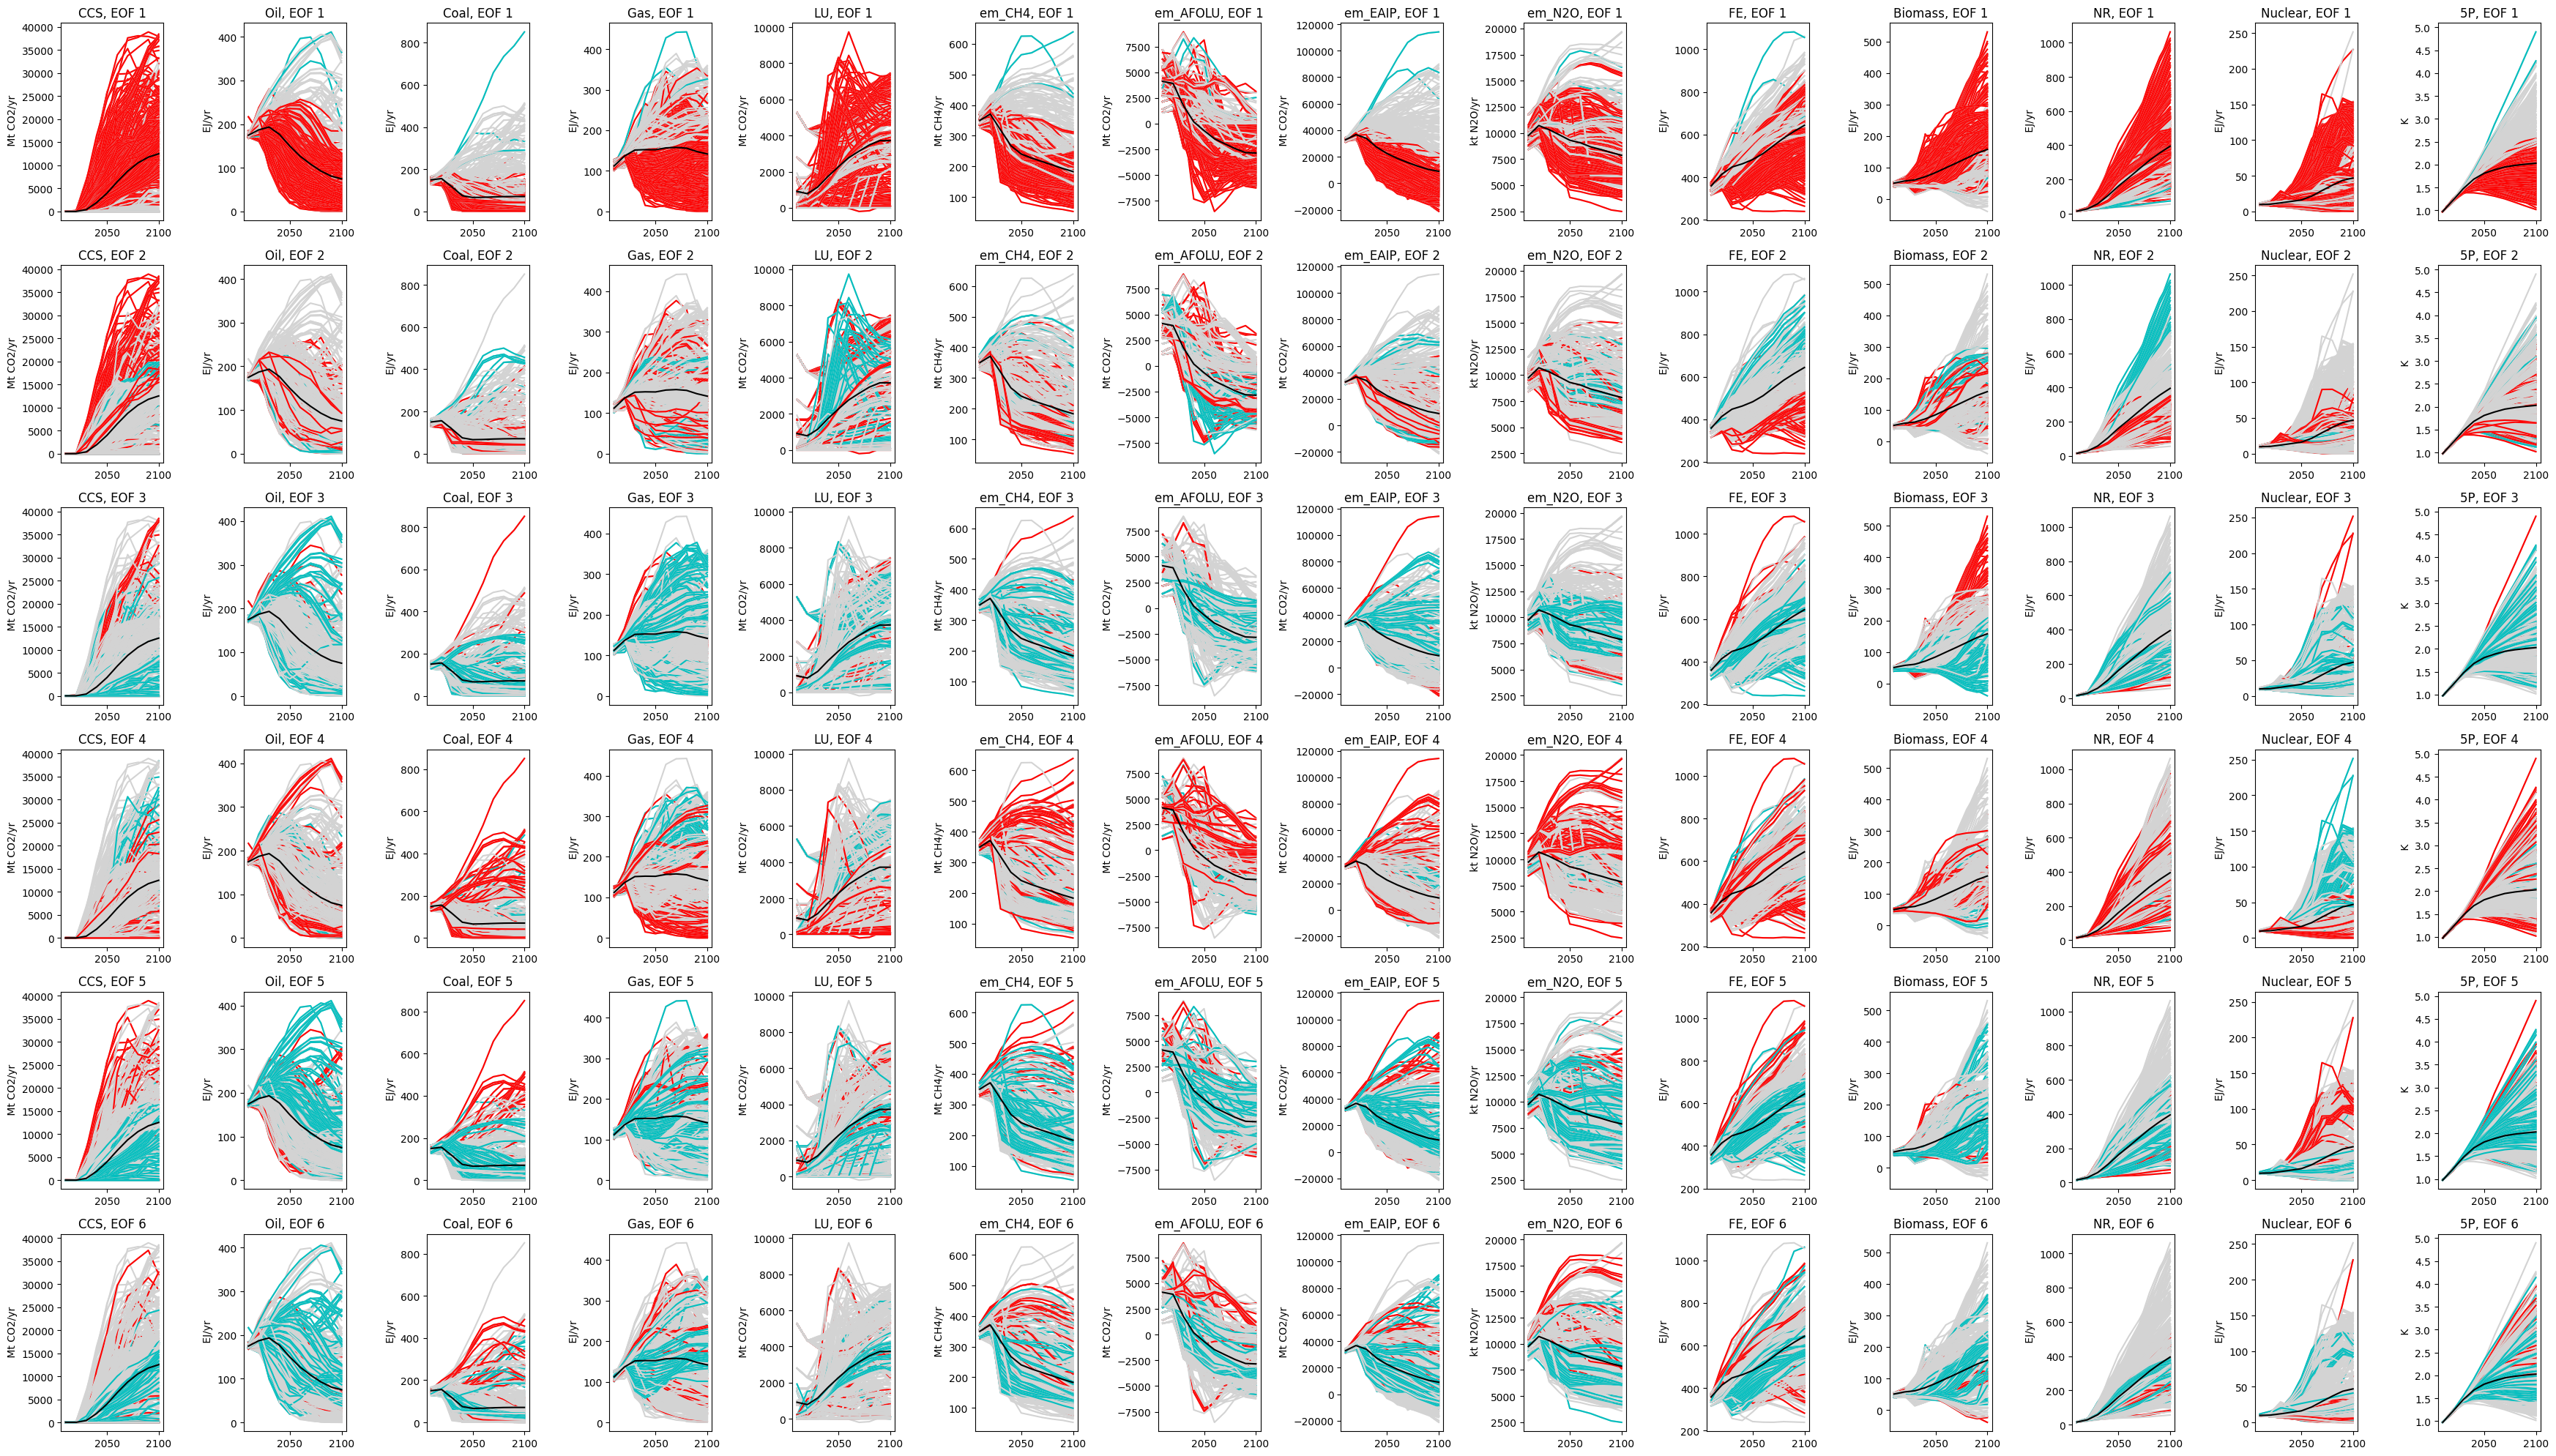

In [29]:
fig, ax = plt.subplots(nrows=6, ncols=len(fld_scl),figsize=(35,20))
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        for k in range(tb[fields[j]].T.shape[1]):
          x=pcs[:,i]
          nx = (x-min(x))/(max(x)-min(x))
        #col.plot(years,tb[fields[j]].iloc[k],color=[np.square(nx[k]),np.square((1-nx[k])),np.square((1-nx[k]))])
          col.plot(years,tb[fields[j]].iloc[k],color='lightgrey')
          if nx[k]>0.7:
            col.plot(years,tb[fields[j]].iloc[k],color='r')
          if nx[k]<0.3:
            col.plot(years,tb[fields[j]].iloc[k],color='c')
        col.plot(years,tb[fields[j]].mean(),color='k')
        col.set_ylabel(' '+tb[fields[j]].unit)
        col.set_title(fld_shrt[j]+', EOF '+str(i+1))
fig.tight_layout()








empirical descriptions for each EOF

In [30]:
solver.eofs(neofs=6)[0].shape

(6, 10)

In [31]:
trunc=20

In [32]:
from scipy.stats.qmc import LatinHypercube
from scipy.stats.qmc import scale

In [33]:
sampler = LatinHypercube(d=trunc)
sample = sampler.random(n=10000)

In [34]:
l_bounds = np.min(np.matmul(solver.pcs(npcs=trunc),np.diag(fcdr[0:trunc])),0)
u_bounds = np.max(np.matmul(solver.pcs(npcs=trunc),np.diag(fcdr[0:trunc])),0)
sample_scaled = scale(sample, l_bounds, u_bounds)

(array([  1.,   0.,   2.,  24.,  30.,  37.,  86., 121., 293., 160.]),
 array([-3121.62480067, -2723.48649563, -2325.34819059, -1927.20988555,
        -1529.07158052, -1130.93327548,  -732.79497044,  -334.6566654 ,
           63.48163964,   461.61994468,   859.75824972]),
 <BarContainer object of 10 artists>)

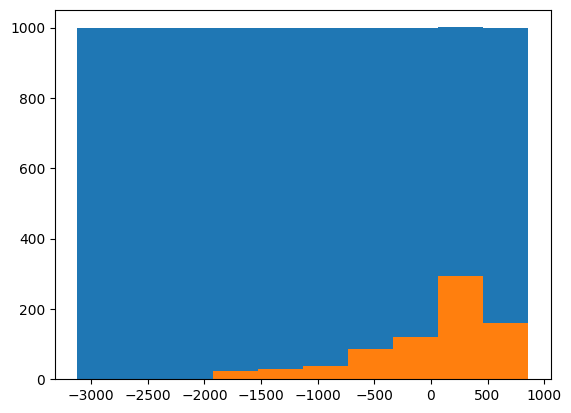

In [35]:
plt.hist(sample_scaled[:,0])
plt.hist(np.matmul(solver.pcs(npcs=trunc),np.diag(fcdr[0:trunc]))[:,0])

In [36]:
recon_org=np.matmul(np.matmul(solver.pcs(npcs=trunc),np.diag(fcdr[0:trunc])),solver.eofs(neofs=trunc))
recon=np.matmul(sample_scaled,solver.eofs(neofs=trunc))


In [37]:
sample_scaled.shape[0]

10000

In [38]:
inrng=np.zeros((sample_scaled.shape[0],len(eof_in)))
for i,f in enumerate(fields):
  inrng[:,i]=np.sum(((recon[i,:,:]+np.mean(eof_in[i][:,:].T,1)[None,:])-np.min(eof_in[i][:,:].T,1)[None,:])<0,1)+np.sum(((recon[i,:,:]+np.mean(eof_in[i][:,:].T,1)[None,:])-np.max(eof_in[i][:,:].T,1)[None,:])>0,1)>0



In [39]:
nngflds=[0,1,2,3,5,8,9,11,12]

nngflds=[True,True,True,True,False,True,False,False,True,True,False,True,True,False]
isng=np.zeros((sample_scaled.shape[0],len(eof_in)))
for i,f in enumerate(fields):
  if nngflds[i]:
    isng[:,i]=np.sum((recon[i,:,:]+np.mean(eof_in[i][:,:].T,1)[None,:])<0,1)>0
  else:
    isng[:,i]=0


0

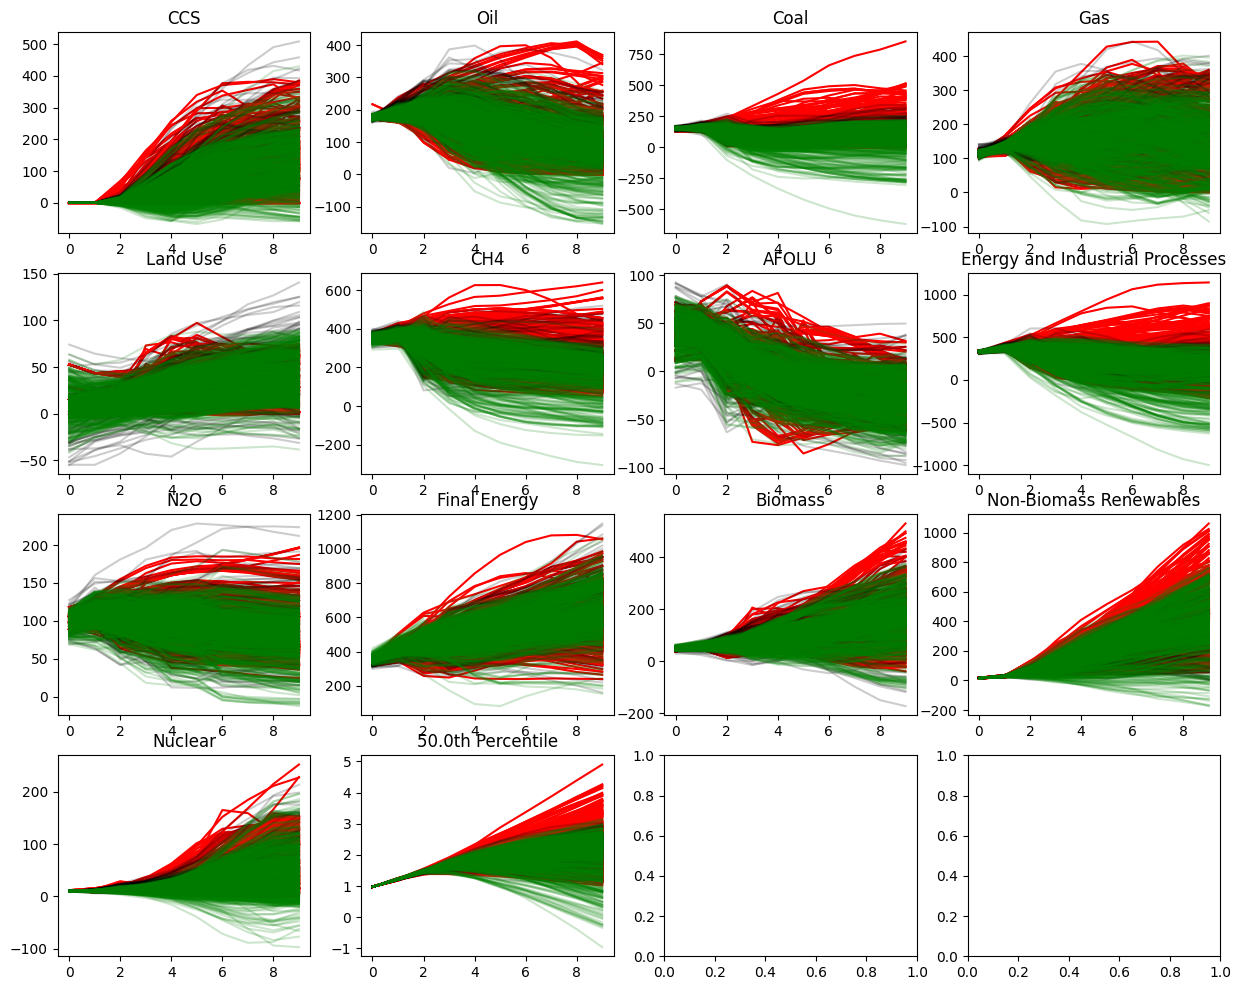

In [40]:
fig, ax = plt.subplots(4, 4, figsize=(15, 12))
ax=ax.flatten()

for i,f in enumerate(fields):
  ax[i].plot(eof_in[i][:,:].T,'r')
  ax[i].plot((recon[i,np.sum(isng,1)==0,:]+np.mean(eof_in[i][:,:].T,1)[None,:]).T,'k',alpha=.2)
  ax[i].plot((recon_org[i,:,:]+np.mean(eof_in[i][:,:].T,1)[None,:]).T,'g',alpha=.2)

  #ax[i].plot((recon[i,np.abs((recon[-1,:,:]+np.mean(eof_in[-1][:,:].T,1)[None,:])[:,-1]-1.5)<0.05,:]+np.mean(eof_in[i][:,:].T,1)[None,:]).T,'g',alpha=.2)
  ax[i].set_title(f)
0


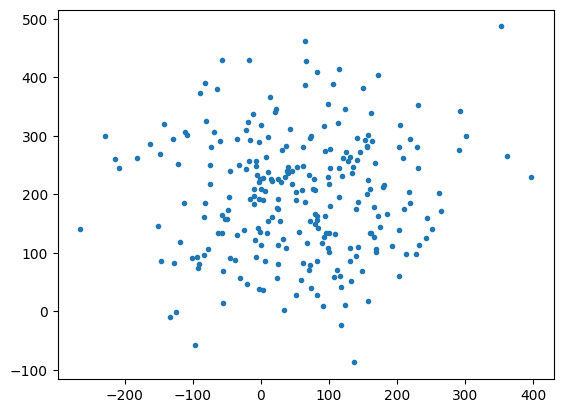

In [41]:
is15=np.abs((recon[-1,:,:]+np.mean(eof_in[-1][:,:].T,1)[None,:])[:,-1]-1.5)<0.05
plt.plot(recon[0,is15,-1]+np.mean(eof_in[0][-1,:].T),recon[3,is15,-1]+np.mean(eof_in[3][-1,:].T),'.')

In [42]:
np.abs((recon[-1,:,:]+np.mean(eof_in[-1][:,:].T,1)[None,:])[:,-1]-1.5)<0.05

array([False, False, False, ..., False, False, False])

In [43]:
EOF_desc=['Low Demand','Rapid CCS, high Nat. gas','Rapid CCS & Oil','Decrease coal & mitigate SLCF','Short term low demand','Rapid oil phaseout']

In [44]:
from itertools import groupby,islice
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)
def add_line1(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + 1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
    #return [(k, sum(1 for i in g)) for k,g in zip(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        if level==1:
          for label in df.index.get_level_values(level):
            lxpos = (pos + 1)*scale
            ax.text(lxpos, ypos, label, ha='right', va='top' ,transform=ax.transAxes,rotation='vertical')
            add_line(ax, pos*scale, ypos)
            pos += 1
        else:
          for label, rpos in label_len(df.index,level):
            lxpos = (pos + 0.5 * rpos + 0.5)*scale
            ax.text(lxpos, ypos, label, ha='right', va='top' ,transform=ax.transAxes,rotation=30)
            add_line1(ax, pos*scale, ypos)
            pos += rpos
        add_line1(ax, pos*scale , ypos)
        ypos -= 1

/tmp/ipykernel_24864/3734645405.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("bwr",7)


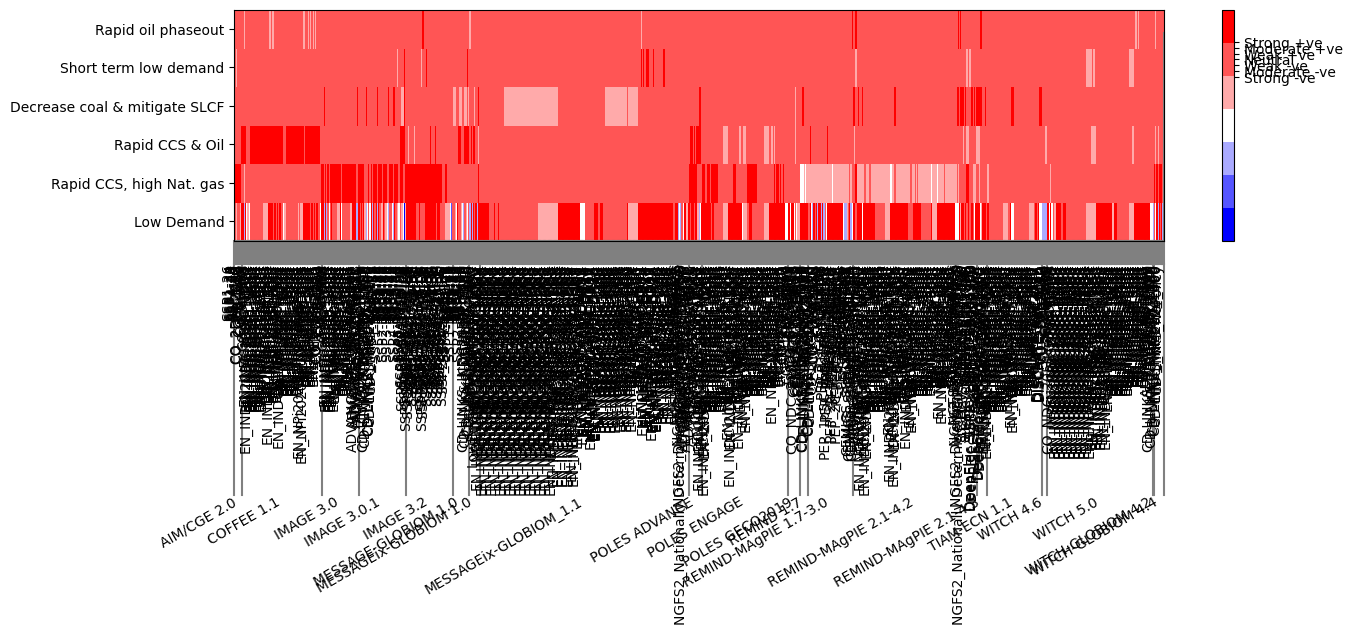

In [45]:
plt.figure(figsize=(15,3))

cmap = plt.cm.get_cmap("bwr",7)
plt.pcolor(pcs.T, cmap=cmap)
ax=plt.gca()
ax.set_yticks(np.arange(0.5,6))
ax.set_yticklabels(EOF_desc)
ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, tb['CCS'])
cb=plt.colorbar()
cb.set_ticks([-300,-200,-100,0,100,200,300])
cb.set_ticklabels(['Strong -ve','Moderate -ve','Weak -ve','Neutral','Weak +ve','Moderate +ve','Strong +ve'])